### Image Classification using LBP and HOG features
이번 실습에서는 CIFAR-10 dataset에서 LBP와 HOG feature를 추출하고 이를 Random Forest classification 학습과 성능을 살펴본다.

In [63]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# pylint: disable=missing-docstring
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import re
import sys
import time
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# own python codes
sys.path.append(os.path.join(os.getcwd(), '..'))
from utils import *
from cifar10_loader import CIFAR10_loader

from skimage import feature
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import numpy as np
 
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius
 
    def describe(self, image):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        lbp = feature.local_binary_pattern(image, self.numPoints,
                                           self.radius)
        (hist, _) = np.histogram(lbp.ravel(),
                                 bins=16)
        
        # return the histogram of Local Binary Patterns
        return hist, lbp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


skimage.feature.local_binary_pattern(image, P, R, method)
- image: (N, M) array
- P: number of neighbors
- R: number of radius
(P = R * 8)
- method: {'default', 'ror', 'uniform', 'var'}

output: (N, M) array

### Download the CIFAR-10 dataset
**CIFAR-10** dataset은 32x32 사이즈의 이미지들로 airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck으로 이루어져있다. 각 클래스 별 6천장씩 구성되어 있으며 이중 50000장이 training에 사용되고 10000장이 test에 사용된다. TF-Slim library에서 제공하는 코드를 이용하여 현재 작업중인 폴더의 하위 폴더에 cifar-10 dataset을 저장한다.

*CIFAR datasets URL*: https://www.cs.toronto.edu/~kriz/cifar.html

*CIFAR-10 download link*: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [64]:
data_dir = '../cifar10_data'
data_url = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
maybe_download_and_extract(data_url, data_dir, 'cifar-10-batches')

Extracting Finished


### Create data loader and check the CIFAR-10 dataset
위에서 다운받은 데이터를 batch 단위로 읽어올 수 있는 data loader class를 선언. 현재 data loader는 get_batch()를 통해 단순히 이미지 및 레이블을 batch 크기만큼 받아올 수 있으며, 여기서는 특별한 preprocessing을 하지는 않는다. 하지만 보통 더 높은 성능을 위해서 random crop, flipping 등의 preprocessing을 하는 편이다.

In [65]:
loader = CIFAR10_loader()
class_names = loader.get_class_names()

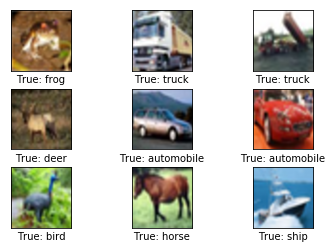

In [66]:
batch = loader.get_batch(9)
fig = plot_images(batch['images'], batch['labels'], class_names)
fig.show()

사용할 LBP의 points와 radius를 정의하고 각 training image에서 추출된 LBP, HOG, ground truth를 저장할 변수를 선언한다.

In [67]:
# initialize the local binary patterns descriptor along with
# the data and label lists
desc = LocalBinaryPatterns(8, 1) # num of points and radius

train_lbp = []
train_hog = []
train_labels = []

LBP와 HOG feature를 추출하기 위해 gray scale로 image를 변환하고 scikit-image library에 정의된 함수를 이용하여 각 feature를 추출한다.

In [68]:
loader.reset()

for ii in range(50000):
    # Load a batch data
    batch = loader.get_batch(1, 'train')
    
    images = batch['images'].reshape(32,32,3) * 255
    images = images.astype('uint8')
    
    gray = cv2.cvtColor(images, cv2.COLOR_BGR2GRAY)

    fd = feature.hog(gray, orientations=9, pixels_per_cell=(8, 8), 
             cells_per_block=(4, 4))
    
    hist, lbp = desc.describe(gray)
    if ii % 1000 == 0:
        print("feature gen: %d" % ii)
        print(hist)
        print(len(fd))
        print(lbp.max())
        print(lbp.min())
    train_labels.append(batch['labels'])
    train_lbp.append(hist)
    train_hog.append(fd)

feature gen: 0
[205 132   8  67  34   4  16  55  49  17   2  24  80   3  98 230]
144
255.0
0.0
feature gen: 1000
[196 181   8  75  27   9  18  52  39  12   0  16  69  10 124 188]
144
255.0
0.0
feature gen: 2000
[312 222   5  68  20   7  15  71  34  16   3  25  36  10  49 131]
144
255.0
0.0
feature gen: 3000
[186 126   6  34  63   6  12  44  53  12   1  31  82   7 133 228]
144
255.0
0.0
feature gen: 4000
[138 120   3 141  25   0  13  95 113  11   1  19  87   4  79 175]
144
255.0
0.0
feature gen: 5000
[170  88   8  79  45   6  21 138  72   9   3  14  84   8  55 224]
144
255.0
0.0
feature gen: 6000
[209 136   9  57  24   2  22  52  63  12   4  12 100  10 108 204]
144
255.0
0.0
feature gen: 7000
[165  95   8 135  38   8  16 138  52  12   2  27  54  12  46 216]
144
255.0
0.0
feature gen: 8000
[204 167   8  67  20   3  18  74  39  11   2  17  72   9 115 198]
144
255.0
0.0
feature gen: 9000
[215 135   7  54  26   3  15  54  59  17   2  16  84  16 103 218]
144
255.0
0.0
feature gen: 10000
[138

### Random Forest Classifier 선언
scikit-image library에 정의된 RandomForestClassifier()를 이용하여 선언한다. 이 함수에서 사용될 수 있는 인자는 아래 링크에 자세히 나와있으며 그 중 중요한 인자들은 아래와 같다.

link: *http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier*


- n_estimaters: number of trees
- criterion: gini / entropy (impurity 계산 방식)
- max_features: number of features to consider
- max_depth
- max_samples_split: number of children nodes


In [70]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier()

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(np.concatenate((train_lbp, train_hog), axis=1), train_labels)

/home/hanul/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Testset data에서 추출한 lbp, hog feature와 ground truth label 정보를 저장할 변수를 선언한다.

In [73]:
loader.reset()

test_lbp = []
test_hog = []
test_labels = []

for ii in range(10000):
    # Load a batch data
    batch = loader.get_batch(1, 'test')
    
    images = batch['images'].reshape(32,32,3) * 255
    images = images.astype('uint8')
    
    gray = cv2.cvtColor(images, cv2.COLOR_BGR2GRAY)
    
    fd = feature.hog(gray, orientations=9, pixels_per_cell=(8, 8), 
             cells_per_block=(4, 4))
    
    hist, lbp = desc.describe(gray)
    if ii % 1000 == 0:
        print("feature gen: %d" % ii)
        print(len(hist))
        print(len(fd))
    test_labels.append(batch['labels'])
    test_lbp.append(hist)
    test_hog.append(fd)

feature gen: 0
16
144
feature gen: 1000
16
144
feature gen: 2000
16
144
feature gen: 3000
16
144
feature gen: 4000
16
144
feature gen: 5000
16
144
feature gen: 6000
16
144
feature gen: 7000
16
144
feature gen: 8000
16
144
feature gen: 9000
16
144


생성된 Random Forest Classifier에 testset의 feature vectors를 이용하여 classification을 진행한다.

In [74]:
# Apply the Classifier we trained to the test data (which, remember, it has never seen before)
pred_labels = []

pred_labels = clf.predict(np.concatenate((test_lbp, test_hog), axis=1))

print(len(pred_labels))
print(len(test_labels))

test_labels = [ int(x) for x in test_labels ]

10000
10000


ground truth label과 predicted label를 이용하여 confusion matrix를 생성한다.

In [75]:
# Create confusion matrix
confusion_matrix(test_labels, pred_labels)

array([[531,  65,  83,  34,  43,  31,  16,  26, 137,  34],
       [104, 532,  36,  32,  31,  20,  36,  24,  92,  93],
       [131,  56, 261, 119, 119, 114,  81,  55,  40,  24],
       [ 77,  70, 153, 270,  93, 169,  79,  41,  10,  38],
       [ 55,  68, 129, 122, 293,  54, 127,  89,  30,  33],
       [ 49,  34, 138, 222,  90, 310,  58,  64,  12,  23],
       [ 42,  76,  95,  98, 119,  50, 453,  29,  13,  25],
       [ 55,  67,  95, 108, 117, 107,  40, 318,  30,  63],
       [214, 133,  51,  33,  18,  18,  11,  26, 439,  57],
       [ 91, 193,  36,  51,  56,  38,  25,  75,  73, 362]])

accuracy를 측정한다.

- true positive (TP): number of hit
- true negative (TN): number of correct rejection
- false positive (FP): number of false hit
- false negative (FN): number of false miss


- precision: TP / (TP + FP)
- recall: TP / (TP + FN)
- f1-score (harmonic mean of precision and recall): 1/precision + 1/recall

In [76]:
print(classification_report(test_labels, pred_labels))

             precision    recall  f1-score   support

          0       0.39      0.53      0.45      1000
          1       0.41      0.53      0.46      1000
          2       0.24      0.26      0.25      1000
          3       0.25      0.27      0.26      1000
          4       0.30      0.29      0.30      1000
          5       0.34      0.31      0.32      1000
          6       0.49      0.45      0.47      1000
          7       0.43      0.32      0.36      1000
          8       0.50      0.44      0.47      1000
          9       0.48      0.36      0.41      1000

avg / total       0.38      0.38      0.38     10000

